# The doubling population

Let's play with very simple scenario with a few (simple) mathematical models. The purpose of this exploration is not necessarily to explore the models, but rather to see various bits of Julia syntax and style for dealing with basic analysis.

**Say we observe or believe that every day the population doubles (and there are no deaths)**

Here are some 6 different models for this ...

### Model 1 (discrete time/deterministic)

$$
x(t+1) = \alpha x(t)
$$

with $\alpha = 2$.

### Model 2 (continuous time/deterministic)

$$
\frac{d}{dt} x(t) = \kappa x(t)
$$

with $\kappa = \log(\alpha) = \log(2) \approx 0.693$.

### Model 3 (discrete time/stochastic)

$$
x(t+1) = \sum_{i=1}^{x(t)} \xi_{i,t}
$$

with $E[\xi_{i,t}] = \alpha = 2$.

### Model 4 (continuous time/stochastic/continuous trajectory)

$$
du(t) = \kappa u(t) + d \zeta(t).
$$

And $x(t) = \max(u(t),0)$.

### Model 5 (continuous time/stochastic/discrete trajectory)

A continuous time markov chain with transition rates: $x \to x+1$ at rate $\kappa x$.

### Model 6 (continuous time/stochastic/discrete trajectory/non-Markovian)

A continuous time processs where each doubling per agent has their own distribution. Each agent lives for a duration which is $1$ day on average and then doubles.

---

Let's create trajectories for each of these models over the time horizon $[0,7]$. For the stochastic models lets compute mean trajectories. For those models let's also look at the distribution of $x(t=7)$. 

---

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/git/mine/Workshop_Julia_for_Biologists`


In [2]:
using Plots, DifferentialEquations, Distributions, Random
using StatsPlots, DataFrames, CSV, StatsBase
using DataStructures

In [3]:
const α_const = 2 #\alpha + [TAB]
const κ_const = log(2) #\kappa + [TAB]
const default_t_max = 7
const default_x0 = 1.0;

In [4]:
"""
A generic structure that represents a model trajectory. 

* `t` is treated as an indexable object (array) of times.
* `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`
"""
struct ModelTrajectory
    t
    u
end

ModelTrajectory

In [5]:
? ModelTrajectory

search: ModelTrajectory



A generic structure that represents a model trajectory. 

  * `t` is treated as an indexable object (array) of times.
  * `u` is treated as an indexable object (array) or the trajectory.

This struct can be used in place of outputs of solvers of `DifferentialEquations.jl`


In [6]:
"""
Create a trajectory for model 1.
"""
function model_1_traj(;t_max = default_t_max, x0 = default_x0)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        x *= α_const
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_1_traj

In [7]:
traj1 = model_1_traj()
traj1.t, traj1.u

(0:7, [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0])

Let's create a function for querying/interpolating a trajectory at any given time (within the time range).

In [8]:
function value_at_time(mt, time::Real) #mt is like ModelTrajectory assumed to have fields t, and u
    time < first(mt.t) && error("Time preceeds trajectory")
    i = findfirst((t)->t≥time, mt.t) 
    i == nothing && error("Time exceeds trajectory")
    t1, u1 = mt.t[i], mt.u[i]
    
    #if exact match of time 
    t1 == time && return u1

    #If here then interporlate
    @assert i > 1
    iprev = i-1
    tprev, uprev = mt.t[iprev], mt.u[iprev]
    return uprev + (time-tprev)/(t1-tprev) * (u1-uprev) #interpolate  
end

value_at_time (generic function with 1 method)

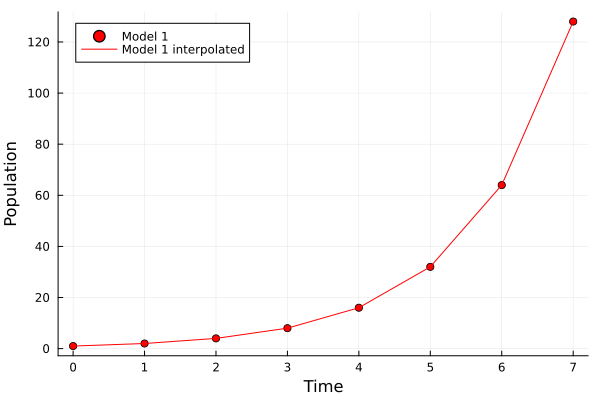

In [9]:
#Plotting Model 1
t_grid = 0:0.01:default_t_max
traj1_on_grid = [value_at_time(traj1,t1) for t1 in t_grid] 
p1 = scatter(traj1.t,traj1.u, 
            c=:red,legend=:topleft, xticks=0:7,
            label="Model 1",xlabel="Time",ylabel="Population")
p2 = plot(p1, t_grid, traj1_on_grid, c=:red,legend=:topleft,label="Model 1 interpolated")

### Moving onto Model 2, let's use ODE Solvers

In [10]:
function model_2_traj(;t_max = default_t_max, x0 = default_x0)
    f(x, p, t) = κ_const * x
    ode_prob = ODEProblem(f, x0, (0,t_max))
    ode_sol = solve(ode_prob, Tsit5(), reltol = 1e-8, abstol = 1e-8)
    return ode_sol
end

model_2_traj (generic function with 1 method)

In [11]:
traj2 = model_2_traj()
traj2.t, traj2.u;

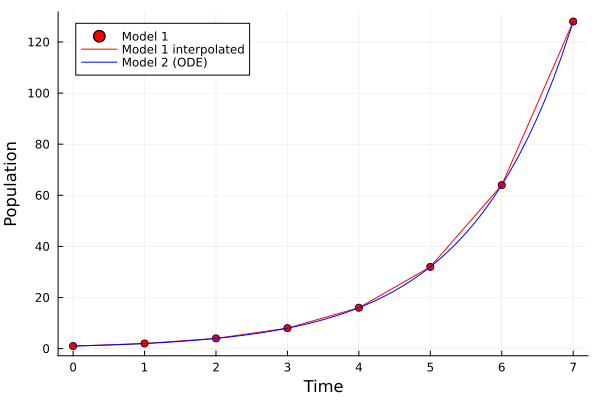

In [12]:
traj2_on_grid = [value_at_time(traj2,t1) for t1 in t_grid] 
p3 = plot(p2, t_grid, traj2_on_grid, c=:blue,legend=:topleft,label="Model 2 (ODE)")

# Going stochastic...

In [13]:
function model_3_traj(;t_max = default_t_max, 
                        x0 = default_x0, 
                        dist_by_mean_generator = Poisson,
                        seed::Union{Nothing,Int} = nothing)
    !isnothing(seed) && Random.seed!(seed)
    dist = dist_by_mean_generator(α_const)
    traj = Array{Float64}(undef, t_max+1)
    x = x0
    traj[1] = x
    for t in 2:(t_max+1)
        offsprings = [rand(dist) for _ in 1:x]
        x = isempty(offsprings) ? 0 : sum(offsprings)
        traj[t] = x
    end
    return ModelTrajectory(0:t_max, traj)
end

model_3_traj (generic function with 1 method)

In [14]:
traj3 = model_3_traj()

ModelTrajectory(0:7, [1.0, 3.0, 9.0, 17.0, 33.0, 70.0, 152.0, 301.0])

In [15]:
traj3_repeats = [model_3_traj().u for _ in 1:10^3]

1000-element Vector{Vector{Float64}}:
 [1.0, 4.0, 3.0, 10.0, 20.0, 41.0, 87.0, 175.0]
 [1.0, 1.0, 2.0, 4.0, 5.0, 6.0, 14.0, 30.0]
 [1.0, 3.0, 4.0, 11.0, 25.0, 47.0, 99.0, 198.0]
 [1.0, 1.0, 6.0, 11.0, 35.0, 70.0, 143.0, 300.0]
 [1.0, 1.0, 1.0, 3.0, 5.0, 12.0, 24.0, 51.0]
 [1.0, 4.0, 7.0, 13.0, 32.0, 62.0, 118.0, 211.0]
 [1.0, 3.0, 4.0, 5.0, 9.0, 17.0, 30.0, 43.0]
 [1.0, 2.0, 4.0, 9.0, 22.0, 41.0, 95.0, 201.0]
 [1.0, 4.0, 13.0, 20.0, 39.0, 82.0, 158.0, 327.0]
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [1.0, 2.0, 3.0, 4.0, 7.0, 17.0, 26.0, 38.0]
 [1.0, 5.0, 15.0, 28.0, 55.0, 102.0, 193.0, 382.0]
 [1.0, 2.0, 6.0, 12.0, 23.0, 53.0, 113.0, 235.0]
 ⋮
 [1.0, 1.0, 2.0, 5.0, 11.0, 23.0, 45.0, 93.0]
 [1.0, 3.0, 4.0, 12.0, 21.0, 38.0, 102.0, 211.0]
 [1.0, 2.0, 4.0, 7.0, 12.0, 26.0, 36.0, 74.0]
 [1.0, 2.0, 7.0, 14.0, 27.0, 47.0, 105.0, 221.0]
 [1.0, 3.0, 5.0, 8.0, 13.0, 26.0, 50.0, 104.0]
 [1.0, 2.0, 3.0, 5.0, 7.0, 15.0, 36.0, 72.0]
 [1.0, 1.0, 2.0, 5.0, 9.0, 17.0, 30.0, 52.0]
 [1.0, 3.0, 10.0, 28

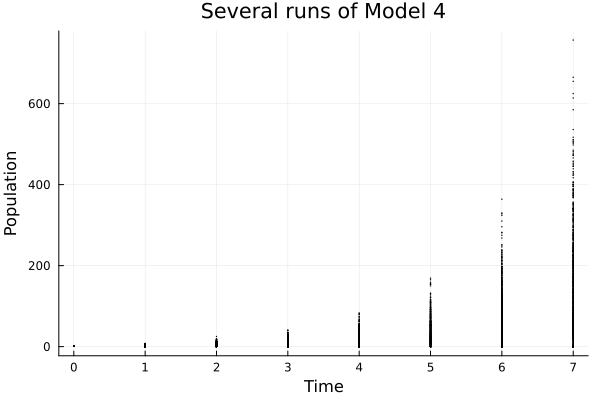

In [16]:
p4 = scatter(traj3.t, hcat(traj3_repeats...), 
        c=:black,ms=0.8,msw=0,legend=:topleft,label=false, xticks=0:7,
        xlabel="Time",ylabel="Population",
        title="Several runs of Model 4")

In [17]:
traj3_means = mean(traj3_repeats)

8-element Vector{Float64}:
   1.0
   2.035
   4.112
   8.198
  16.305
  32.716
  65.508
 131.14

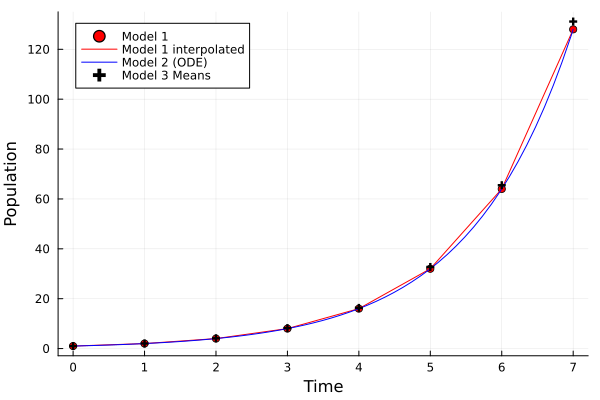

In [18]:
p4 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:cross,legend=:topleft,msw=3,label="Model 3 Means")

Let's increase to a million repeats

  4.846196 seconds (9.05 M allocations: 1.521 GiB, 12.94% gc time, 0.57% compilation time)


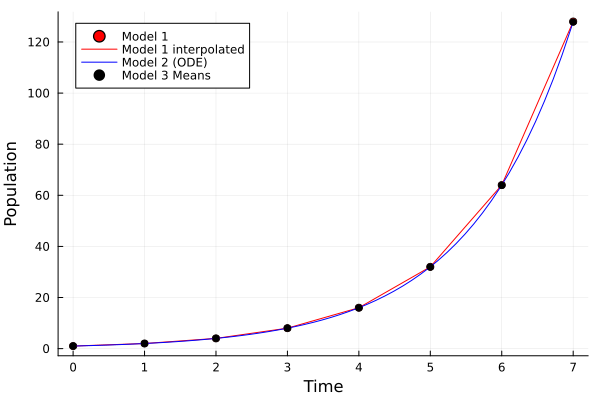

In [19]:
@time begin #See also BenchmarkTools.jl for better timing support
    traj3_repeats = [model_3_traj().u for _ in 1:10^6];
end
traj3_means = mean(traj3_repeats)
p5 = scatter(p3, traj3.t, traj3_means, c=:black,marker=:black,legend=:topleft,msw=2,label="Model 3 Means")

### Now SDE

In [20]:
function model_4_traj(;t_max = default_t_max, x0 = default_x0, dt = 1//2^(4), positive_only = false)
    x0 = rand(Normal(x0, 1))
    f(u,p,t) = κ_const*u
    g(u,p,t) = u > 0 ? 1 : 0
    sode_prob = SDEProblem(f,g,x0,(0.0,t_max))
    sode_sol = solve(sode_prob, EM(), dt=dt)
    positive_only ? ModelTrajectory(sode_sol.t, map((u)->max(u,0), sode_sol.u) ) : sode_sol
end

model_4_traj (generic function with 1 method)

In [21]:
traj4_t = model_4_traj().t
first(traj4_t,5)

5-element Vector{Float64}:
 0.0
 0.0625
 0.125
 0.1875
 0.25

In [22]:
traj4_repeats_a = [model_4_traj().u for _ in 1:10^2];
traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^2];

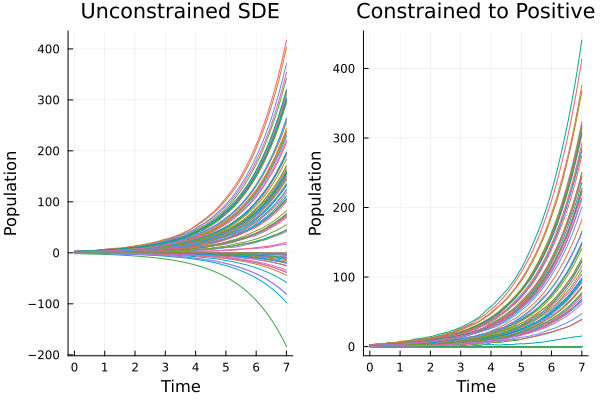

In [23]:
plot_args = (legend=false,xlabel="Time",ylabel="Population", xticks = 0:7)
pa = plot(traj4_t, hcat(traj4_repeats_a...), title = "Unconstrained SDE"; plot_args...)
pb = plot(traj4_t, hcat(traj4_repeats_b...), title = "Constrained to Positive"; plot_args...)
plot(pa,pb)

In [24]:
@time traj4_repeats_a = [model_4_traj().u for _ in 1:10^5];
@time traj4_repeats_b = [model_4_traj(positive_only=true).u for _ in 1:10^5];
@time traj4_means_a = mean(traj4_repeats_a)
@time traj4_means_b = mean(traj4_repeats_b)
first(traj4_means_a,3), first(traj4_means_b,3)

  2.393248 seconds (12.85 M allocations: 777.078 MiB, 9.59% gc time, 3.58% compilation time)
  2.577963 seconds (13.38 M allocations: 894.662 MiB, 5.75% gc time, 2.15% compilation time)
  0.093836 seconds (100.00 k allocations: 96.131 MiB, 51.45% gc time)
  0.073149 seconds (100.00 k allocations: 96.131 MiB)


([0.9985511734062721, 1.0420972136946778, 1.0879609063108748], [1.084443369532369, 1.1349330670147828, 1.1862410137477806])

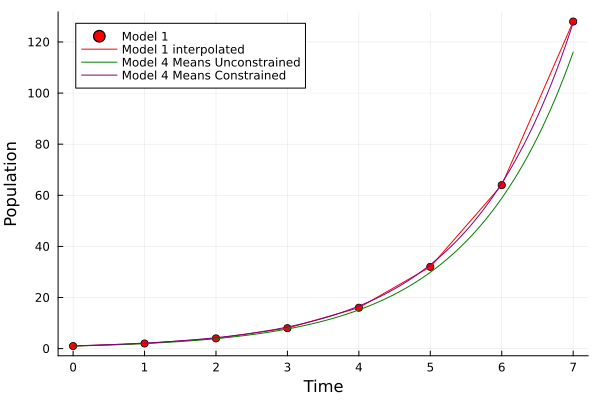

In [25]:
plot(p2, traj4_t, [traj4_means_a traj4_means_b], 
                c=[:green :purple], legend=:topleft, msw=0, 
                label=["Model 4 Means Unconstrained" "Model 4 Means Constrained"])

# Storing results/data in file

Say we want to store results at times:

In [26]:
times_of_results = [0.0, 2.5, 5.0, 5.9, 6.7]

5-element Vector{Float64}:
 0.0
 2.5
 5.0
 5.9
 6.7

In [27]:
model4df = DataFrame()
sims = [model_4_traj(positive_only=true) for _ in 1:10^4];
for time in times_of_results
    model4df[:,replace("Time$time","." => "_")] = [value_at_time(sim, time) for sim in sims]
end

In [28]:
names(model4df)

5-element Vector{String}:
 "Time0_0"
 "Time2_5"
 "Time5_0"
 "Time5_9"
 "Time6_7"

In [29]:
CSV.write("model4.csv",model4df)

"model4.csv"

### Continuous Time Markov Chain (Markov Jump Process)

In [30]:
function model_5_traj(;t_max = default_t_max, x0 = default_x0)
    t, x = 0.0 , x0
    t_values, u_values = [t], [x]
    while t < t_max
        t += rand(Exponential(1/(x*κ_const)))
        x += 1
        push!(t_values,t)
        push!(u_values,x)
    end
    return ModelTrajectory(t_values, u_values)
end

model_5_traj (generic function with 1 method)

In [31]:
traj5 = model_5_traj()
traj5.t, traj5.u

([0.0, 1.2779558778771352, 1.7614909639862275, 2.6355339765154437, 2.9734917045713654, 2.997645765589196, 3.2819107928140014, 3.903027614954326, 3.9164837213984534, 3.9422442693291395  …  6.907545029605571, 6.909154982999648, 6.918550905554717, 6.934701565650519, 6.939433468834986, 6.939550796637651, 6.947743723393731, 6.956539868357409, 6.994272426641636, 7.031200017753682], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0])

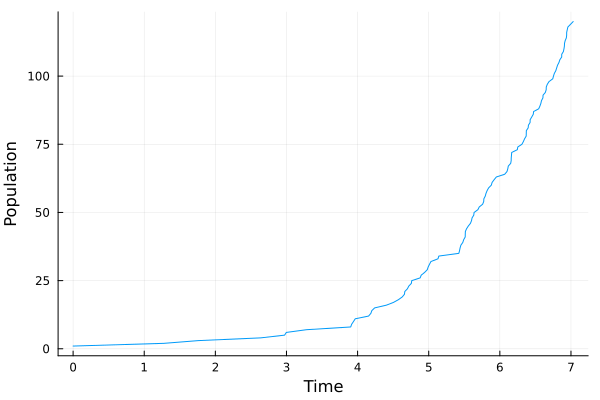

In [32]:
#Plotting of the trajectory for Model 5 - but something is a bit wrong... (what is it?)
plot(traj5.t, traj5.u;plot_args...)

In [33]:
#Function helping plotting
function stich_steps(model_trajectory)
    t, u = model_trajectory.t, model_trajectory.u
    n = length(t)
    new_t  = [ t[1] ]
    new_u = [ u[1] ]
    for i in 2:n
        push!(new_t, t[i])
        push!(new_u, u[i-1])
        push!(new_t, t[i])
        push!(new_u, u[i])
    end
    return ModelTrajectory(new_t, new_u)
end

stich_steps (generic function with 1 method)

In [34]:
traj5_stiched = stich_steps(traj5)

ModelTrajectory([0.0, 1.2779558778771352, 1.2779558778771352, 1.7614909639862275, 1.7614909639862275, 2.6355339765154437, 2.6355339765154437, 2.9734917045713654, 2.9734917045713654, 2.997645765589196  …  6.939550796637651, 6.939550796637651, 6.947743723393731, 6.947743723393731, 6.956539868357409, 6.956539868357409, 6.994272426641636, 6.994272426641636, 7.031200017753682, 7.031200017753682], [1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0  …  115.0, 116.0, 116.0, 117.0, 117.0, 118.0, 118.0, 119.0, 119.0, 120.0])

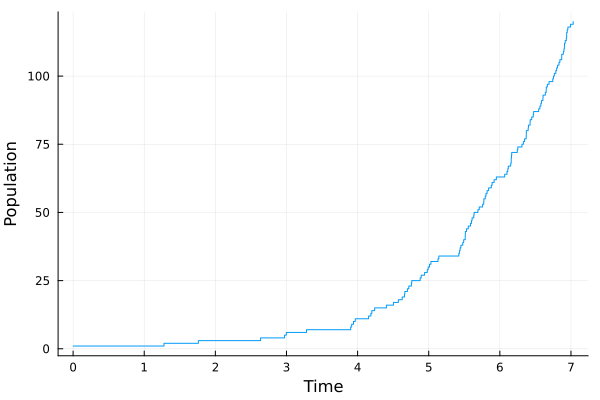

In [35]:
plot(traj5_stiched.t, traj5_stiched.u, legend=false;plot_args...)

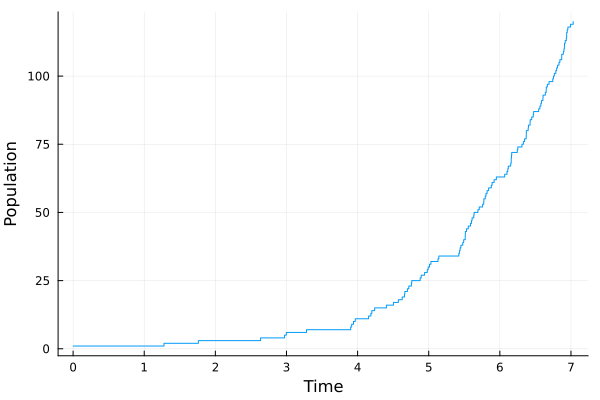

In [36]:
plot(traj5_stiched.t, traj5_stiched.u, legend=false;plot_args...)

In [37]:
traj5_repeats = [model_5_traj() for _ in 1:10];
traj5_repeats_stiched = stich_steps.(traj5_repeats);

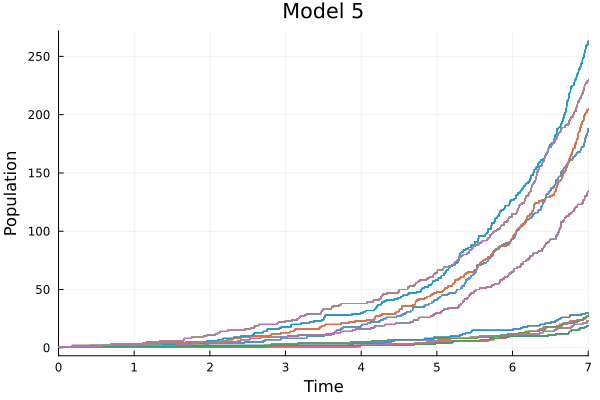

In [38]:
times = [mt.t for mt in traj5_repeats_stiched]
vals = [mt.u for mt in traj5_repeats_stiched]
p = plot(title = "Model 5")
for i in 1:length(times)
    plot!(times,vals;plot_args...,xlim=(0,7))
end
p

In [39]:
function value_at_time(mt, time::Real, jump_process::Bool=true) 
    time < first(mt.t) && error("Time preceeds trajectory")
    i = findfirst((t)->t≥time, mt.t) 
    i == nothing && error("Time exceeds trajectory")
    
    #if exact match of time 
    mt.t[i] == time && return mt.u[i]

    #Otherwise prev time...
    @assert i > 1
    return mt.u[i-1]    
end

value_at_time (generic function with 2 methods)

In [40]:
methods(value_at_time)

# 2 methods for generic function "value_at_time":
[1] value_at_time(mt, time::Real) in Main at In[39]:1
[2] value_at_time(mt, time::Real, jump_process::Bool) in Main at In[39]:1

In [41]:
Random.seed!(0)
traj5 = model_5_traj()

ModelTrajectory([0.0, 1.4555369011918016, 1.528580982636026, 1.9312783105482008, 2.048463811926414, 2.2645397537731813, 2.3632855702197126, 2.4085306574750978, 2.4325789130379603, 2.4518622060619695  …  6.946142846996933, 6.948893600367086, 6.95218686810082, 6.957170676074483, 6.9593554658737435, 6.959496504076371, 6.982206772066854, 6.990601021397845, 6.999642565836232, 7.005596967597079], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0  …  257.0, 258.0, 259.0, 260.0, 261.0, 262.0, 263.0, 264.0, 265.0, 266.0])

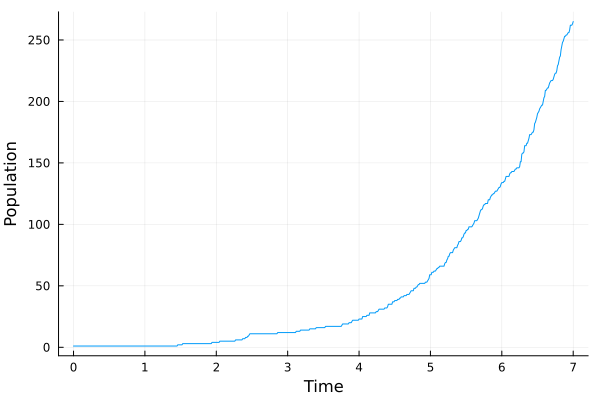

In [42]:
t_grid = 0:0.01:7
vals = [value_at_time(traj5, t ,true) for t in t_grid]
plot(t_grid,vals;plot_args...)

  0.079279 seconds (122.24 k allocations: 61.841 MiB, 39.13% compilation time)


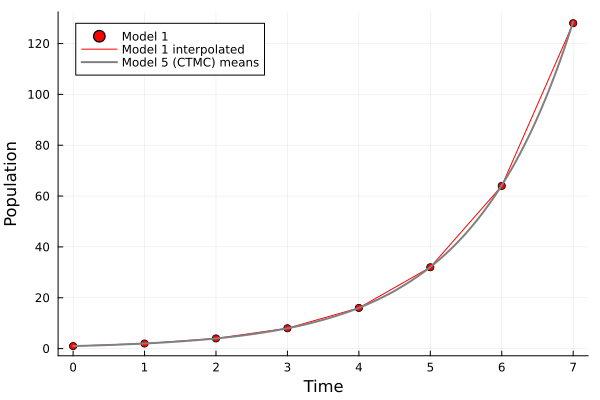

In [43]:
@time trajs = [model_5_traj() for _ in 1:10^4]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
plot(p2,t_grid,means,lw=2,c=:grey,label="Model 5 (CTMC) means")

┌ Info: Saved animation to /Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists/sampleAnim.gif
└ @ Plots /Users/uqjnazar/.julia/packages/Plots/zzg7i/src/animation.jl:149


Plots.AnimatedGif("/Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists/sampleAnim.gif")
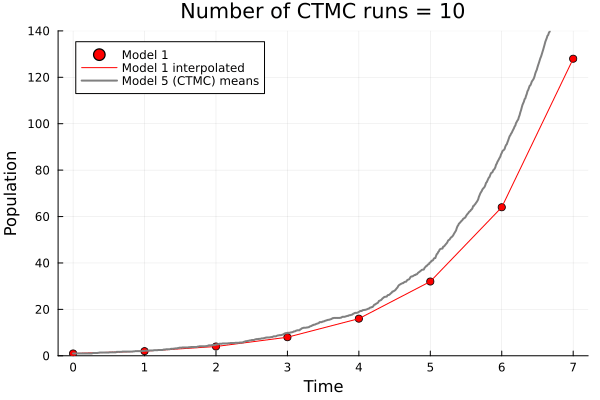

In [44]:
anim = Animation()
for N in [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 10000]
    Random.seed!(0)
    trajs = [model_5_traj() for _ in 1:N]
    means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
    plot(p2,t_grid,means,lw=2,c=:grey,ylim=(0,140),label="Model 5 (CTMC) means", title = "Number of CTMC runs = $N")
    frame(anim)
end

gif(anim, "sampleAnim.gif", fps = 1.5)

# Model 6 - Agent/Discrete-Event

In [45]:
function model_6_traj(;t_max = default_t_max, x0 = default_x0, life_time_till_doubling_dist = Exponential(1/κ_const) )
    population = BinaryMinHeap{Float64}()
    for _ in x0
        push!(population, rand(life_time_till_doubling_dist) )
    end
    current_time = 0.0
    t_values, u_values = [current_time], [length(population)]

    while current_time <= t_max 
        current_time = pop!(population)
        for _ in 1:2
            push!(population, current_time + rand(life_time_till_doubling_dist) )
        end
        push!(t_values, current_time)
        push!(u_values, length(population))
    end
    return ModelTrajectory(t_values, u_values)
end

model_6_traj (generic function with 1 method)

In [46]:
traj6_repeats = [model_6_traj() for _ in 1:10];
traj6_repeats_stiched = stich_steps.(traj6_repeats);

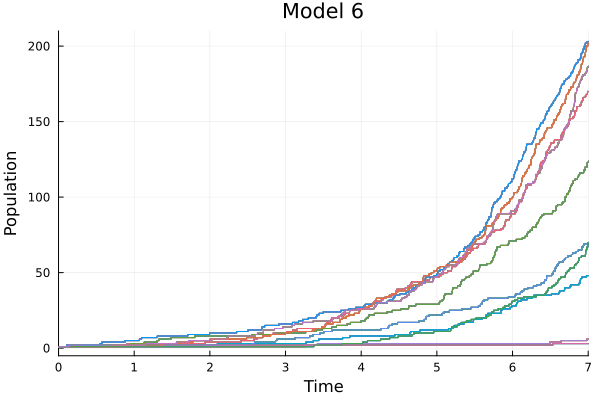

In [47]:
times = [mt.t for mt in traj6_repeats_stiched]
vals = [mt.u for mt in traj6_repeats_stiched]
p = plot(title = "Model 6")
for i in 1:length(times)
    plot!(times,vals;plot_args...,xlim=(0,7))
end
p

  0.045685 seconds (59.37 k allocations: 11.179 MiB, 57.53% compilation time)


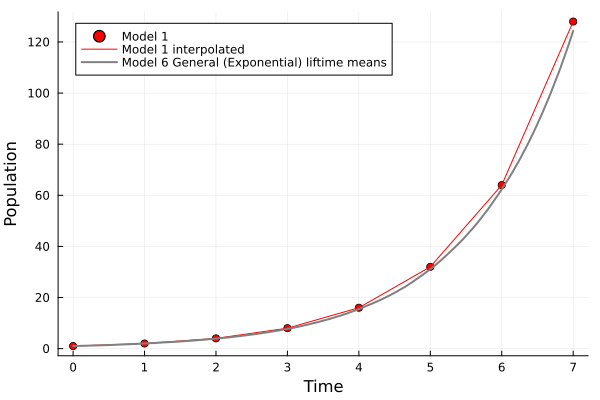

In [48]:
@time trajs = [model_6_traj() for _ in 1:10^3]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
p7 = plot(p2,t_grid,means,lw=2,c=:grey,label="Model 6 General (Exponential) liftime means")

But if we change the liftime distribution shape things change...

In [49]:
default_dist = Exponential(1/κ_const)
new_dist = Uniform(0,2/κ_const)
mean(default_dist), mean(new_dist)

(1.4426950408889634, 1.4426950408889634)

  0.109423 seconds (254.49 k allocations: 16.638 MiB, 93.37% compilation time)


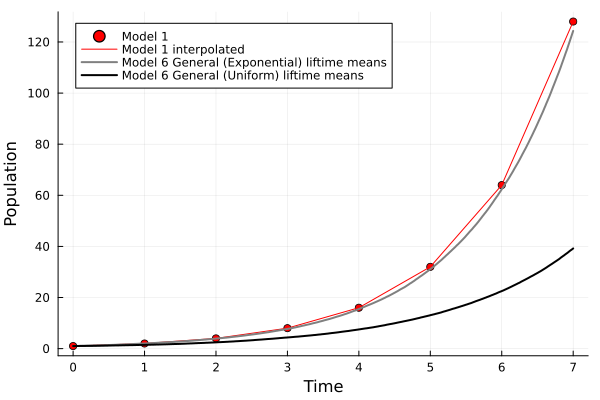

In [50]:
@time trajs = [model_6_traj(life_time_till_doubling_dist=new_dist) for _ in 1:10^3]
means = [mean([value_at_time(traj, t, true) for traj in trajs]) for t in t_grid]
plot(p7,t_grid,means,lw=2,c=:black,label="Model 6 General (Uniform) liftime means")

# Challange

Try to "calibrate" Model 6 so that it behaves on average like the other models.

# Reading results from file

In [51]:
pwd()

"/Users/uqjnazar/git/mine/Workshop_Julia_for_Biologists"

In [52]:
readdir()

10-element Vector{String}:
 ".git"
 ".gitignore"
 ".ipynb_checkpoints"
 "Manifest.toml"
 "Project.toml"
 "README.md"
 "TheDoublingPopulation.ipynb"
 "demo_julia_syntax.jl"
 "model4.csv"
 "sampleAnim.gif"

In [53]:
df = CSV.File("model4.csv") |> DataFrame

Row,Time0_0,Time2_5,Time5_0,Time5_9,Time6_7
,Float64,Float64,Float64,Float64,Float64
1,1.19424,8.26867,53.1442,98.0492,169.523
2,0.0,0.0,0.0,0.0,0.0
3,1.60788,14.8693,80.9801,149.433,257.483
4,2.74612,18.2925,100.417,184.15,316.887
5,1.39499,9.46442,58.1802,107.825,186.325
6,2.68934,17.0512,90.4349,163.872,281.813
7,1.12786,9.59791,48.6062,90.0226,153.073
8,1.46923,12.6707,74.264,137.509,237.04
9,2.31539,0.911327,0.0,0.0,0.0


In [54]:
using StatsBase

In [55]:
summarystats(df.Time5_0)

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           32.204775
Minimum:        0.000000
1st Quartile:   0.000000
Median:         26.767927
3rd Quartile:   55.588860
Maximum:        220.624202


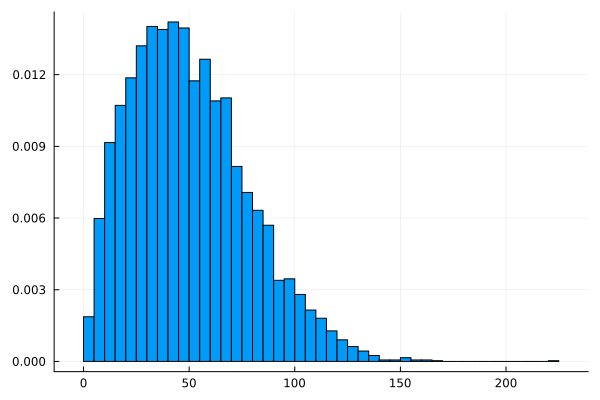

In [56]:
histogram(filter((x)->x>0,df.Time5_0), label=false, normed=true)

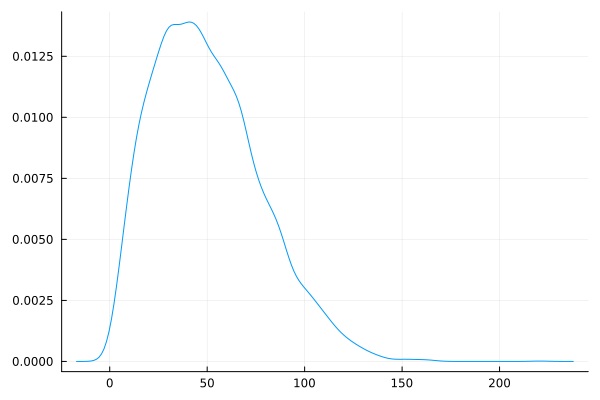

In [57]:
density(filter((x)->x>0,df.Time5_0), label=false)

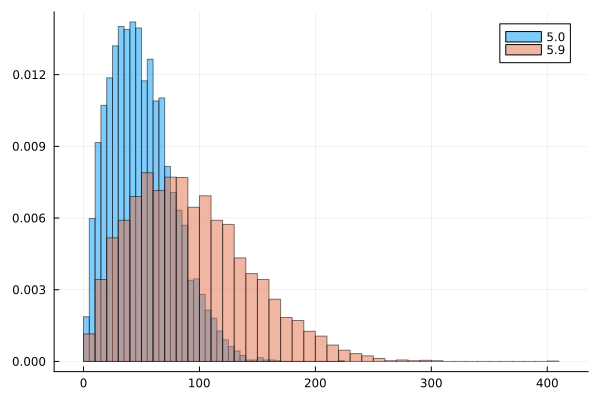

In [58]:
histogram([filter((x)->x>0,df.Time5_0),filter((x)->x>0,df.Time5_9)], label=["5.0" "5.9"], normed=true,alpha=0.5)

# Exercise

Create an animation of the distribution of the population size of time. Compare animations for the various models.